In [2]:
import torch
from torchvision import datasets, transforms
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
import helper
from torch import optim,nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.models as models


--2020-02-03 17:35:12--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-02-03 17:35:12 (82.0 MB/s) - ‘helper.py’ saved [2813/2813]



In [3]:
#Data part after collection of data
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
#!ls = '/content/drive/My Drive//image/'
!ls= 'gdrive/My Drive/Data classification/image/train'
#root_path

/bin/bash: gdrive/My Drive/Data classification/image/train: No such file or directory


In [0]:
#Transform and loading the data
train_transformer = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                       ])
                                      

test_transformer = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]) 

train_dir = '/content/gdrive/My Drive/Data classification/train'
test_dir = '/content/gdrive/My Drive/Data classification/test'

In [0]:
#loading the dataset
traindata = datasets.ImageFolder(train_dir, transform = train_transformer)
testdata = datasets.ImageFolder(test_dir, transform = test_transformer )

#loading the data loader
trainloader = torch.utils.data.DataLoader(traindata, batch_size = 3, shuffle = True)
testloader = torch.utils.data.DataLoader(testdata,batch_size = 3, shuffle =True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


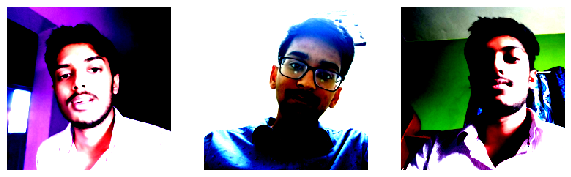

In [6]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,3), ncols=3)
for ii in range(3):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

In [7]:
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [8]:
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
for param in model.parameters():
  param.req_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                                        
                          ('fc1',nn.Linear(2048, 1024)),
                           ('relu',nn.ReLU()),
                           #('dropout',nn.Dropout(0.2)),
                           ('fc2',nn.Linear(1024,2)),
                           ('output',nn.LogSoftmax(dim=1))
                           ]))

model.fc = classifier

In [0]:
import time


In [11]:
for device in ['cpu','cuda']:

  criterion = nn.NLLLoss()
  #only train the classifier parameters
  optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

  model.to(device)

  for ii, (inputs, labels) in enumerate(trainloader):

    #move input and label tensors to the GPU
    inputs,labels= inputs.to(device), labels.to(device)

    start = time.time()

    outputs = model.forward(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    if ii==3:
      break

  print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")





Device = cpu; Time per batch: 1.320 seconds
Device = cuda; Time per batch: 0.024 seconds


In [12]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()



Epoch 1/5.. Train loss: 1.785.. Test loss: 1.929.. Test accuracy: 0.455
Epoch 1/5.. Train loss: 0.933.. Test loss: 0.792.. Test accuracy: 0.545
Epoch 1/5.. Train loss: 1.060.. Test loss: 1.374.. Test accuracy: 0.545
Epoch 1/5.. Train loss: 0.839.. Test loss: 0.615.. Test accuracy: 0.606
Epoch 1/5.. Train loss: 0.707.. Test loss: 1.019.. Test accuracy: 0.455
Epoch 1/5.. Train loss: 0.674.. Test loss: 0.848.. Test accuracy: 0.485
Epoch 1/5.. Train loss: 0.648.. Test loss: 0.674.. Test accuracy: 0.818
Epoch 1/5.. Train loss: 0.691.. Test loss: 0.821.. Test accuracy: 0.394
Epoch 1/5.. Train loss: 0.606.. Test loss: 0.797.. Test accuracy: 0.485
Epoch 1/5.. Train loss: 0.783.. Test loss: 0.665.. Test accuracy: 0.545
Epoch 2/5.. Train loss: 0.843.. Test loss: 0.590.. Test accuracy: 0.606
Epoch 2/5.. Train loss: 0.720.. Test loss: 0.740.. Test accuracy: 0.606
Epoch 2/5.. Train loss: 0.556.. Test loss: 0.888.. Test accuracy: 0.485
Epoch 2/5.. Train loss: 0.643.. Test loss: 0.744.. Test accuracy

In [0]:
checkpoint = {'input_size': 2048,
              'output_size': 2,
              
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'classification.pth')

In [17]:
git remote add origin https://github.com/Anubhav1107/Face-Classification-using-Transfer-Learning.git
git push -u origin master

SyntaxError: ignored